# Setting my google drive as my current working directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Image_processing

/content/drive/MyDrive/Image_processing


# About the data: 
## The HAM10000 training set includes the following skin lesions:
*   akiec - Actinic Keratoses 
*   bcc -   Basal cell carcinoma
*   bkl -   Benign keratosis
*   df  -   Dermatofibroma
*   nv   -  Melanocytic nevi
*   mel -   Melanoma
*   vasc -  Vascular skin lesions 

Body parts where moles were found: **scalp, ear, face, back, trunk, chest, 
upper extremity, abdomen, unknown, lower extremity, genital, neck, hand, foot, acral**

# **Loading the necessary libraries**

In [ ]:
!pip3 install autokeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 4.9 MB/s 
     |████████████████████████████████| 133 kB 52.3 MB/s 
     |████████████████████████████████| 462 kB 49.6 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

np.random.seed(42)
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pydot

### Reading the data

In [ ]:
skin_df = pd.read_csv('HAM10000_metadata.csv')
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


# Data visualisation 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


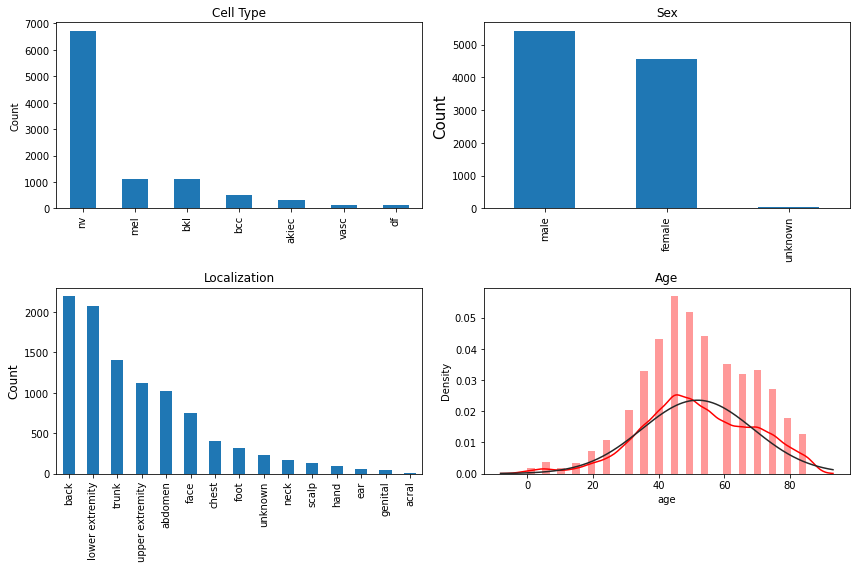

In [ ]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()


In [ ]:
# Distribution of data
print(skin_df['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [ ]:
# Creating dictionary for image path, and lesion type
# Adding images from both the folders

image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('*', '*.jpg'))}


lesion_type_dict = {
    'akiec': 'Actinic keratoses (akiec)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'df': 'Dermatofibroma (df)',
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',    
    'vasc': 'Vascular lesions (vasc)',
}
label_mapping = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'nv',
    5: 'mel',
    6: 'vasc'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [ ]:
# Adding cell_type and image_path columns
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['path'] = skin_df['image_id'].map(image_path.get)

In [ ]:
#Checking the new df
skin_df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path
1617,HAM_0007180,ISIC_0033272,mel,histo,65.0,male,face,Melanoma (mel),HAM10000_images_part_2/ISIC_0033272.jpg
8128,HAM_0007195,ISIC_0031923,nv,histo,40.0,female,lower extremity,Melanocytic nevi (nv),HAM10000_images_part_2/ISIC_0031923.jpg
2168,HAM_0001835,ISIC_0026652,mel,histo,65.0,male,back,Melanoma (mel),HAM10000_images_part_1/ISIC_0026652.jpg
1090,HAM_0000465,ISIC_0030583,bkl,consensus,35.0,female,trunk,Benign keratosis-like lesions (bkl),HAM10000_images_part_2/ISIC_0030583.jpg
7754,HAM_0001720,ISIC_0034010,nv,histo,45.0,male,abdomen,Melanocytic nevi (nv),HAM10000_images_part_2/ISIC_0034010.jpg


In [ ]:
# Adding image pixels
skin_df['image_pixel'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

In [ ]:
skin_df['label'] = skin_df['dx'].map(reverse_label_mapping.get)

In [ ]:
skin_df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
3697,HAM_0005218,ISIC_0028939,nv,follow_up,55.0,female,lower extremity,Melanocytic nevi (nv),HAM10000_images_part_1/ISIC_0028939.jpg,"[[[226, 163, 193], [228, 167, 196], [230, 173,...",4
7213,HAM_0007444,ISIC_0033989,nv,histo,50.0,female,lower extremity,Melanocytic nevi (nv),HAM10000_images_part_2/ISIC_0033989.jpg,"[[[163, 161, 182], [162, 161, 182], [161, 162,...",4
310,HAM_0002839,ISIC_0032280,bkl,histo,60.0,female,lower extremity,Benign keratosis-like lesions (bkl),HAM10000_images_part_2/ISIC_0032280.jpg,"[[[105, 84, 92], [106, 85, 94], [109, 88, 98],...",2
4438,HAM_0005070,ISIC_0030863,nv,follow_up,55.0,female,trunk,Melanocytic nevi (nv),HAM10000_images_part_2/ISIC_0030863.jpg,"[[[239, 151, 171], [240, 152, 171], [242, 150,...",4
6087,HAM_0005969,ISIC_0028257,nv,follow_up,35.0,male,abdomen,Melanocytic nevi (nv),HAM10000_images_part_1/ISIC_0028257.jpg,"[[[214, 132, 135], [209, 132, 136], [216, 143,...",4


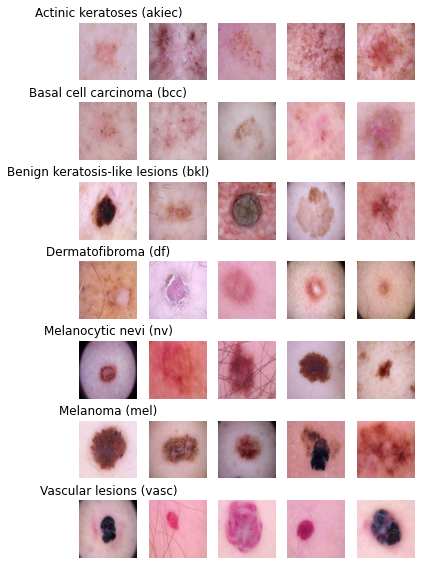

In [ ]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (6,10),)
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['dx']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image_pixel'])
        c_ax.axis('off')

In [ ]:
abcd = skin_df[['cell_type','label']].drop_duplicates()
abcd.sort_values(by='cell_type',ascending=True)
abcd.reset_index(drop=True)
abcd.sort_values(by='cell_type',ascending=True)

,cell_type,label
9687,Actinic keratoses (akiec),0
2462,Basal cell carcinoma (bcc),1
0,Benign keratosis-like lesions (bkl),2
1095,Dermatofibroma (df),3
64,Melanocytic nevi (nv),4
1211,Melanoma (mel),5
2320,Vascular lesions (vasc),6


In [ ]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = skin_df['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(skin_df['label'])
Y_cat = to_categorical(Y_orig, num_classes=7) #Convert to categorical as this is a multiclass classification problem

print(X_orig.shape)
print(Y_orig.shape)

(10015, 224, 224, 3)
(10015,)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_orig, Y_cat, test_size=0.2, random_state=42, shuffle = True)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Prepare data for training and testing the model
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                  rotation_range = 10, # randomly rotate images in the range (degrees, 0 to 180)
                                  zoom_range = 0.1, # randomly zoom image
                                  width_shift_range = 0.2, # randomly shift images horizontally (fraction of total width)
                                  height_shift_range = 0.2, # randomly shift images vertically (fraction of total height)
                                  shear_range = 0.2,
                                  horizontal_flip = True, # randomly flip images
                                  vertical_flip = True, # randomly flip images
                                  validation_split = 0.2,
                                  fill_mode = 'nearest')

datagen_batch_size = 15 

train_generator = train_datagen.flow(X_train,Y_train, batch_size = datagen_batch_size)

In [ ]:
X_train.shape

(8012, 224, 224, 3)

In [ ]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications.mobilenet_v2 import MobileNetV2

base_model=MobileNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3))

model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          737344    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 64)          0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                           

In [ ]:
history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = 10)
print(history)

Epoch 1/10
101/101 [==============================] - 817s 8s/step - loss: 1.1627 - acc: 0.6478 - val_loss: 6.7533 - val_acc: 0.6719
Epoch 2/10
101/101 [==============================] - 767s 8s/step - loss: 0.7825 - acc: 0.7182 - val_loss: 9.5664 - val_acc: 0.6719
Epoch 3/10
101/101 [==============================] - 769s 8s/step - loss: 0.6888 - acc: 0.7525 - val_loss: 2.0750 - val_acc: 0.6719
Epoch 4/10
101/101 [==============================] - 761s 8s/step - loss: 0.6283 - acc: 0.7880 - val_loss: 2.8761 - val_acc: 0.6712
Epoch 5/10
101/101 [==============================] - 764s 8s/step - loss: 0.6560 - acc: 0.7797 - val_loss: 2.5971 - val_acc: 0.6719
Epoch 6/10
101/101 [==============================] - 769s 8s/step - loss: 0.5950 - acc: 0.7945 - val_loss: 2.6522 - val_acc: 0.6725
Epoch 7/10
101/101 [==============================] - 769s 8s/step - loss: 0.5067 - acc: 0.8318 - val_loss: 1.6116 - val_acc: 0.6918
Epoch 8/10
101/101 [==============================] - 767s 8s/step - 

In [ ]:
model.save('model.h5')

In [ ]:
X_train.shape

(8012, 224, 224, 3)

In [ ]:
Y_train.shape

(8012, 7)

In [ ]:
from sklearn.metrics import classification_report

def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    sample_data = X_test[:15]
    plt.figure(figsize=(10, 5))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.axis("off")
    plt.show() 

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([[7.51213580e-02, 4.04671691e-02, 3.81333977e-01, ...,
        3.21044832e-01, 1.53248072e-01, 6.48534531e-03],
       [1.30935205e-05, 1.97837608e-06, 1.49863050e-03, ...,
        7.78412998e-01, 2.20070884e-01, 5.66527831e-07],
       [3.51596333e-04, 2.59961653e-05, 6.17474597e-03, ...,
        8.01670551e-01, 1.91684544e-01, 1.52149687e-05],
       ...,
       [2.32153980e-06, 4.97037078e-08, 7.62335141e-04, ...,
        8.78096223e-01, 1.21138968e-01, 7.64607488e-09],
       [2.63714514e-06, 2.15467807e-07, 6.17130892e-04, ...,
        8.29366028e-01, 1.70013219e-01, 8.67795151e-08],
       [5.11007627e-08, 1.13923711e-10, 4.50109183e-05, ...,
        9.97280478e-01, 2.67442921e-03, 1.01288691e-11]], dtype=float32)

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test accuracy:', score[1])

63/63 [==============================] - 33s 522ms/step - loss: 2.0539 - acc: 0.6575
Test accuracy: 0.6575137376785278


In [ ]:
# Prediction on test data
y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(Y_test, axis = 1) 

from sklearn.metrics import confusion_matrix

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

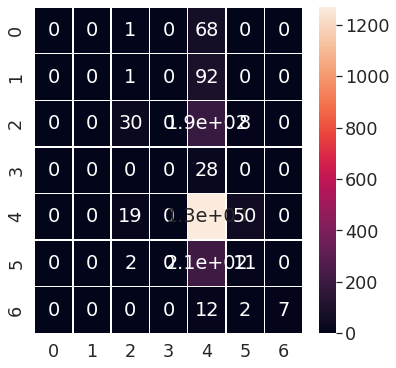

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)